In [7]:
import numpy as np
import torch
import torch.nn as nn
from collections import Counter
from itertools import chain
import torch.optim as optim
import os
import random
random.seed(42)

In [8]:
# Step 1: Load GloVe Embeddings
def load_glove_embeddings(file_path, embedding_dim):
    """
    Load GloVe embeddings from the file into a dictionary.
    """
    embedding_dict = {}
    with open(file_path, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]  # The word
            vector = np.array(values[1:], dtype="float32")  # The embedding vector
            embedding_dict[word] = vector
    print(f"Loaded {len(embedding_dict)} word vectors.")
    return embedding_dict


In [9]:
# Tokenize comments
def tokenize_comments(comments, vocab):
    tokenized_comments = []
    for comment in comments:
        tokens = comment.split()  # Simple whitespace tokenizer
        token_indices = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
        tokenized_comments.append(token_indices)
    return tokenized_comments

# Pad sequences to a fixed length
def pad_sequences(sequences, max_len, pad_value):
    padded_sequences = []
    for seq in sequences:
        if len(seq) < max_len:
            seq = seq + [pad_value] * (max_len - len(seq))
        else:
            seq = seq[:max_len]
        padded_sequences.append(seq)
    return padded_sequences

In [10]:
# Step 3: Create the Embedding Matrix
def create_embedding_matrix(vocab, glove_embeddings, embedding_dim):
    """
    Create an embedding matrix where each row corresponds to a token in the vocabulary.
    """
    vocab_size = len(vocab)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))  # Initialize matrix with zeros

    for word, idx in vocab.items():
        if word in glove_embeddings:
            embedding_matrix[idx] = glove_embeddings[word]
        else:
            # Initialize randomly for missing words
            embedding_matrix[idx] = np.random.uniform(-0.01, 0.01, embedding_dim)

    return embedding_matrix

In [11]:
# Path to GloVe file and embedding dimensions
glove_file_path = "glove.6B.100d.txt"
embedding_dim = 100

In [12]:
# Load GloVe embeddings
glove_embeddings = load_glove_embeddings(glove_file_path, embedding_dim)


Loaded 400001 word vectors.


In [13]:
# Step 2: Build Vocabulary
# Example tokenized dataset (replace with your dataset tokens)
vocab_file = 'imdb.vocab'
with open(vocab_file, 'r') as f:
    vocab_words = f.read().splitlines()

tokenized_sentences = vocab_words
tokenized_sentences.append('<UNK>')  # Add <UNK> token for unknown words
tokenized_sentences.append('<PAD>')  # Add <PAD> token to pad sequences
# Create vocabulary
vocab_size = len(vocab_words)
# tokens = list(chain(*tokenized_sentences))
vocab_counter = Counter(tokenized_sentences)


In [14]:
# Assign an index to each word in the vocabulary
vocab = {word: idx for idx, (word, _) in enumerate(vocab_counter.most_common())}
print(f"Vocabulary size: {len(vocab)}")


Vocabulary size: 89529


In [15]:
# Create embedding matrix
embedding_matrix = create_embedding_matrix(vocab, glove_embeddings, embedding_dim)
print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (89529, 100)


In [16]:
# Step 4: Load Embedding Matrix into PyTorch Embedding Layer
embedding_tensor = torch.tensor(embedding_matrix, dtype=torch.float32)

# Define the embedding layer
embedding_layer = nn.Embedding(len(vocab), embedding_dim)
embedding_layer.weight.data.copy_(embedding_tensor)  # Load pre-trained weights

tensor([[-3.8194e-02, -2.4487e-01,  7.2812e-01,  ..., -1.4590e-01,
          8.2780e-01,  2.7062e-01],
        [-7.1953e-02,  2.3127e-01,  2.3731e-02,  ..., -7.1895e-01,
          8.6894e-01,  1.9539e-01],
        [-2.7086e-01,  4.4006e-02, -2.0260e-02,  ..., -4.9230e-01,
          6.3687e-01,  2.3642e-01],
        ...,
        [-9.4564e-04, -2.7440e-03,  3.9987e-04,  ...,  1.5346e-04,
         -6.2992e-03,  1.0258e-03],
        [ 1.5657e-03,  5.9044e-03, -1.3577e-03,  ...,  1.8260e-03,
         -5.7033e-03, -5.0751e-03],
        [ 5.2405e-03, -7.4625e-03,  5.5885e-03,  ...,  2.2042e-03,
          3.8700e-03, -6.9762e-03]])

In [17]:
# Optionally freeze the embedding layer
embedding_layer.weight.requires_grad = False
print("Embedding layer is ready.")

# Step 5: Test the Embedding Layer
example_sentence = ["this", "movie", "is", "great"]  # Example input sentence
token_indices = [vocab.get(token, vocab["<UNK>"]) for token in example_sentence]


Embedding layer is ready.


In [18]:
# Convert token indices to a PyTorch tensor
input_tensor = torch.tensor(token_indices).unsqueeze(0)  # Add batch dimension

# Pass through the embedding layer
output_embeddings = embedding_layer(input_tensor)
print(f"Input indices: {token_indices}")
print(f"Output embeddings shape: {output_embeddings.shape}")


Input indices: [9, 15, 5, 83]
Output embeddings shape: torch.Size([1, 4, 100])


In [19]:


# Output embedding for visualization
print("Output embeddings for the example sentence:")
print(output_embeddings.shape)


Output embeddings for the example sentence:
torch.Size([1, 4, 100])


In [20]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix=None, freeze_embeddings=True):
        super(SentimentLSTM, self).__init__()
        
        # Step 1. Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.tensor(embedding_matrix, dtype=torch.float32))  # Load pre-trained embeddings
            self.embedding.weight.requires_grad = not freeze_embeddings  # Freeze or allow fine-tuning
        
        # Step 2. LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True)
        
        # Step 3. Fully Connected Layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        # Step 4. Sigmoid Activation for Binary Classification
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Pass input through embedding layer
        embedded = self.embedding(x)
        
        # Pass embeddings through the LSTM layer
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        # Take the output from the last hidden state
        final_output = self.fc(hidden[-1])
        
        # Apply sigmoid activation
        output = self.sigmoid(final_output)
        return output

In [21]:
vocab_size = len(vocab)
embedding_dim = 100  # Same as GloVe
hidden_dim = 128
output_dim = 1
learning_rate = 0.01
num_epochs = 28 # Number of epochs

# Initialize the LSTM model
model = SentimentLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, freeze_embeddings=True)

# Move the model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [22]:

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
batched_comments = []
pos = os.listdir('train/pos')
neg = os.listdir('train/neg')
pos = list(filter(lambda x: '._' not in x, pos))
neg = list(filter(lambda x: '._' not in x, neg))


In [24]:
# Read the comments from files
pos_comments = [open(f'train/pos/{f}', 'r').read() for f in pos]
neg_comments = [open(f'train/neg/{f}', 'r').read() for f in neg]

# Label the comments
pos_labels = [1] * len(pos_comments)
neg_labels = [0] * len(neg_comments)

# Combine and shuffle the comments and labels
comments = pos_comments + neg_comments
labels = pos_labels + neg_labels

In [25]:
combined = list(zip(comments, labels))
random.shuffle(combined)
comments, labels = zip(*combined)

In [26]:
# Create batches of size 50
batch_size = 50
batched_comments = [(comments[i:i + batch_size], labels[i:i + batch_size]) for i in range(0, len(comments), batch_size)]
len(batched_comments)

750

In [27]:
train_size = 0.8
test_size = 0.2
train_len = train_size * len(batched_comments)
test_len = len(batched_comments) - train_len
train_comments = batched_comments[:int(train_len)]
val_comments = labels[:int(train_len)]

test_comments = batched_comments[int(train_len):]
test_labels = labels[int(train_len):]

In [28]:
losses = []
accuracies = []

In [29]:
# Training Loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0

    # Loop through batches
    for comments, labels in train_comments:  # Assuming train_comments is a list of (comments, labels) batches
        # Move data to device
        comments_padded = pad_sequences(tokenize_comments(comments, vocab), max_len=200, pad_value=vocab["<PAD>"])
        
        comments = torch.tensor(comments_padded, dtype=torch.long).to(device)  # Shape: [batch_size, sequence_length]
        labels = torch.tensor(labels, dtype=torch.float32).to(device)  # Shape: [batch_size]

        # Forward pass
        predictions = model(comments).squeeze(1)  # Shape: [batch_size]

        # Compute loss
        loss = criterion(predictions, labels)

        # Backward pass
        optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model weights

        # Accumulate loss and accuracy
        epoch_loss += loss.item()
        preds = (predictions >= 0.5).float()  # Convert probabilities to binary labels
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

    # Print epoch summary
    accuracy = correct_predictions / total_predictions
    losses.append(epoch_loss / len(train_comments))
    accuracies.append(accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_comments):.4f}, Accuracy: {accuracy:.4f}")


Epoch 1/28, Loss: 0.6848, Accuracy: 0.5421
Epoch 2/28, Loss: 0.4838, Accuracy: 0.7730
Epoch 3/28, Loss: 0.4113, Accuracy: 0.8157
Epoch 4/28, Loss: 0.3871, Accuracy: 0.8286
Epoch 5/28, Loss: 0.3681, Accuracy: 0.8366
Epoch 6/28, Loss: 0.3481, Accuracy: 0.8479
Epoch 7/28, Loss: 0.3283, Accuracy: 0.8604
Epoch 8/28, Loss: 0.3133, Accuracy: 0.8685
Epoch 9/28, Loss: 0.2970, Accuracy: 0.8769
Epoch 10/28, Loss: 0.2860, Accuracy: 0.8826
Epoch 11/28, Loss: 0.2682, Accuracy: 0.8921
Epoch 12/28, Loss: 0.2561, Accuracy: 0.8978
Epoch 13/28, Loss: 0.2453, Accuracy: 0.9014
Epoch 14/28, Loss: 0.2364, Accuracy: 0.9058
Epoch 15/28, Loss: 0.2308, Accuracy: 0.9076
Epoch 16/28, Loss: 0.2218, Accuracy: 0.9117
Epoch 17/28, Loss: 0.2172, Accuracy: 0.9146
Epoch 18/28, Loss: 0.2150, Accuracy: 0.9145
Epoch 19/28, Loss: 0.2047, Accuracy: 0.9205
Epoch 20/28, Loss: 0.2068, Accuracy: 0.9194
Epoch 21/28, Loss: 0.1962, Accuracy: 0.9233
Epoch 22/28, Loss: 0.1851, Accuracy: 0.9285
Epoch 23/28, Loss: 0.1931, Accuracy: 0.92

In [30]:
def test_model(model, test_comments, test_labels, batch_size=32):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Disable gradient calculations
        for comment_obj in test_comments:
            # Extract batch
            comments_batch = comment_obj[0]
            labels_batch = comment_obj[1]
            comments_padded = pad_sequences(tokenize_comments(comments_batch, vocab), max_len=200, pad_value=vocab["<PAD>"])

            # Convert to tensors and move to device
            comments = torch.tensor(comments_padded, dtype=torch.long).to(device)
            labels = torch.tensor(labels_batch, dtype=torch.float32).to(device)

            # Forward pass
            predictions = model(comments).squeeze(1)

            # Compute loss
            loss = criterion(predictions, labels)
            total_loss += loss.item()

            # Accuracy calculations
            preds = (predictions >= 0.5).float()
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

    # Compute metrics
    average_loss = total_loss / (len(test_comments) // batch_size)
    accuracy = correct_predictions / total_predictions

    print(f"Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    return average_loss, accuracy

# Call the test function
test_model(model, test_comments, test_labels)


Test Loss: 23.4665, Test Accuracy: 0.7961


(23.466536067426205, 0.7961333333333334)

In [31]:
import matplotlib.pyplot as plt

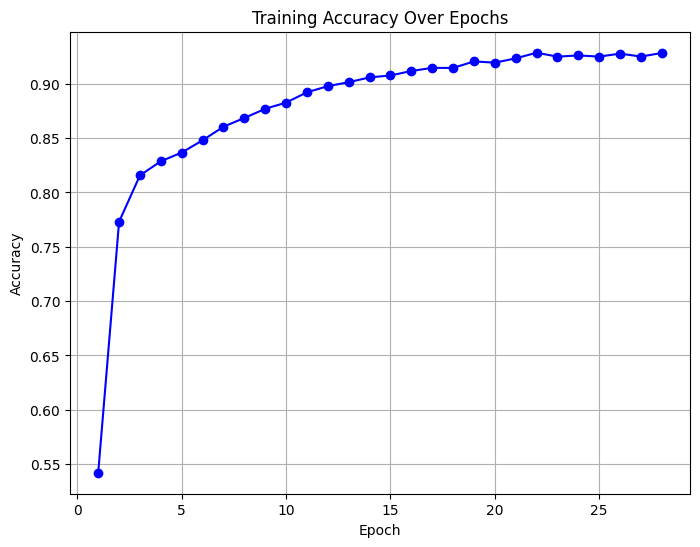

In [32]:
# Plot Accuracy vs. Epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', linestyle='-', color='b')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

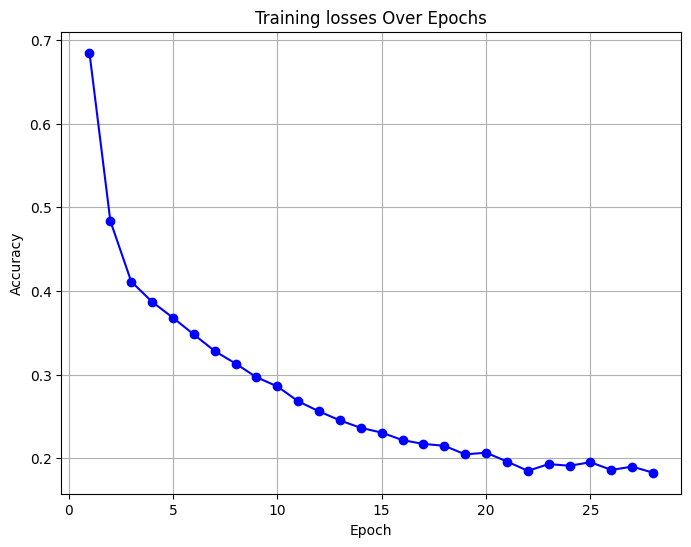

In [33]:
# Plot Accuracy vs. Epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', color='b')
plt.title('Training losses Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [34]:
test_comments[0][0]

("I thought this would be funny. I did. I don't know what happened. But I think a lot of the problem unfortunately falls with the casting. I don't know who this kid is, he could be a very nice person but he wasn't right for this movie. And the supporting cast was great which only makes it more obvious. For example there would be a scene with him and his love interest and your mind just starts to wander off but then Keith David starts speaking, or Leslie Nielsen, or Marion Ross, and it's like someone turned a light on and suddenly you can pay attention again and you think it might not be that bad. But when they get back to the main characters the lights go out again. <br /><br />The spoofing material available in the superhero genre is plentiful so the fact that most of the jokes were basically a fart, makes you wonder who wrote this thing. I mean it had a couple of funny bits, as I do remember laughing a couple of times, but right now I don't remember why and it was only a few days ago

In [35]:

comments_padded = pad_sequences(tokenize_comments(test_comments[0][0], vocab), max_len=200, pad_value=vocab["<PAD>"])


In [36]:
comments_padded

[[89527,
  198,
  9,
  58,
  25,
  89527,
  89527,
  89527,
  89527,
  88,
  119,
  45,
  89527,
  89527,
  89527,
  100,
  2,
  169,
  3,
  0,
  428,
  454,
  703,
  14,
  0,
  89527,
  89527,
  88,
  119,
  32,
  9,
  515,
  89527,
  21,
  95,
  25,
  2,
  52,
  314,
  389,
  16,
  21,
  273,
  201,
  13,
  9,
  89527,
  89527,
  0,
  672,
  172,
  11,
  83,
  59,
  60,
  161,
  6,
  49,
  89527,
  89527,
  446,
  37,
  58,
  25,
  2,
  132,
  14,
  86,
  1,
  23,
  114,
  580,
  1,
  125,
  334,
  40,
  496,
  4,
  6154,
  129,
  16,
  91,
  89527,
  89527,
  496,
  89527,
  39,
  89527,
  89527,
  39,
  89527,
  89527,
  1,
  89527,
  36,
  268,
  676,
  2,
  689,
  18,
  1,
  1044,
  20,
  66,
  993,
  673,
  168,
  1,
  20,
  100,
  6,
  228,
  19,
  25,
  10,
  89527,
  89527,
  50,
  33,
  74,
  141,
  4,
  0,
  283,
  101,
  0,
  2645,
  137,
  44,
  89527,
  89527,
  89527,
  89527,
  11969,
  786,
  1384,
  7,
  0,
  3746,
  505,
  5,
  11875,
  35,
  0,
  186,
  10,
  87,
 